In [1]:
import os
import pandas as pd
import pymongo
import matplotlib.pyplot as plt
from datetime import datetime

os.getcwd()

'C:\\Users\\Alec\\Documents\\Programming_Resources\\Boot_Camp\\personal_projects\\jj_earnings_tracker_LOCAL'

---------------

The first block of Methods takes information from the user to insert into the database

In [2]:
# BLOCK ONE

#-------------------------------------------------------------------------------------------------------------------------#

# set up pymongo connection

# https://docs.mongodb.com/manual/reference/default-mongodb-port/

conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# declare database
db = client.jj_earnings

# declare the collections
shifts = db.shifts

# set wages
current_wage = 9.5 
chipotle_wage = 16.5
#-------------------------------------------------------------------------------------------------------------------------#


def get_date():
    # gets the date in a no frills string, formats to desired output for later use
    # returns variable "date_of_shift"
    # breaks if date != 6 characters
    print("Use 2 characters for the Day, Month, and Year.")
    print("EXAMPLE: 01/15/2022 = 011522")
    print("")
    
    date_string = input("Please input date of shift. ")
    
    # EXIT STRING - returns a string that will cause main_function to return None, preventing data saving to mongoDB
    if (date_string == "cancel") or (date_string == "exit"):
        return date_string
    
    
    else:
        if len(date_string) != 6:
            raise ValueError ('Date Incorrect Format')
        else:
            month = date_string[slice(0,2)]
            day = date_string[slice(2,4)]
            year = date_string[slice(4,6)]
            date_of_shift = f'{month}-{day}-{year}'
            return date_of_shift

#-------------------------------------------------------------------------------------------------------------------------#

def earnings_request():
    
    '''
    This function passes inputs to user then aggregates the user information, 
    
    then returns a Dictionary of the aggregated information.
    
    '''
    
    # asks for information and returns the date & dict of aggregated values
    wage = current_wage
    date_of_shift = get_date()
    
    # EXIT STRING - returns a string that will cause main_function to return None, preventing data saving to mongoDB
    if (date_of_shift == "cancel") or (date_of_shift == "exit"):
        return date_of_shift
    else:
        print("")
        hours = float(input("Hours worked? "))
        if hours <= 0:
            print()
            print('Hours worked cannot be zero - Restart. ')
            raise ValueError
        else:

            # data collection
            tips = float(input("Tips? "))
            start_mileage = input("What was the starting mileage? ")
            end_mileage = input("What was the ending mileage? ")
            start_mileage = int(start_mileage)
            end_mileage = int(end_mileage)
            delta_mileage = end_mileage - start_mileage

            if start_mileage > end_mileage:
                print()
                print('Ending Mileage less than Starting Mileage - Restart')
                raise ValueError

            # data aggregation
            earnings = round(((wage * hours) + tips),2)
            effective_wage = round((earnings / hours), 2)

            old_job_earnings = round((chipotle_wage * hours),2)
            old_job_diff = old_job_earnings - earnings

            # info to return
            entry = {
            "date_of_shift":date_of_shift,
            "tips": tips,
            "hours":hours,
            "earnings":earnings,
            "effective_wage":effective_wage,
            "old_job_earnings":old_job_earnings,
            "old_job_comparison":old_job_diff,
            "starting_mileage": start_mileage,
            "ending_mileage": end_mileage,
            "change_in_mileage": delta_mileage,

            }

    return entry
                

        
#-------------------------------------------------------------------------------------------------------------------------#   return date_of_shift

def main_function():
    '''
    This function sets up two while loops to allow for continual collection of data until a keyword stops the second loop.
    
    The loop collects date, tips earned USD, hours worked, and the starting and ending mileage.
    
    The collected information is aggregated in the earnings_request() method and then sent to a MongoDB for later use.
    
    '''

    finished = 'n'
    # start parent loop
    while finished != 'y':
        loop = True
        # start Child loop
        while loop == True:
            # TRY main data collection 
            # EXCEPT force restart if user input does not meet requirements
            try:
                # run earnings request and pass data to MongoDB after one more user-check.
                shift_data = earnings_request()
                
                # EXIT STRING - returns a string that will cause main_function to return None, preventing data saving to mongoDB
                if (shift_data == "cancel") or (shift_data == "exit"):
                    print("Exiting... No Data Saved.")
                    return
                # else no exit string detected, continue operations
                else:
                
                    print('--------------------------------------')
                    print('Please review info, enter "restart" to restart. ')
        
                    # if finished != 'y' keep looping back to line 123
                    # else stop entire loop and do nothing
                    finished = input('Done? (y/n) ').lower()
                    print('--------------------------------------')
                    # in event of user spotted error in data entry that has mis-spelling but meets data parameters
                    # activate EXCEPT and allow for restart
                    if finished == 'restart':
                        raise ValueError
                    else:

                        print('Sending document to jj_earnings in MongoDB...')
                        print('--------------------------------------')
                        print()
                        shifts.insert_one(shift_data)
                        # END child loop - back to parent loop line 123
                        loop = False
                
            except ValueError:
                print('')
                print('====================================')
                print("Incorrect Data Entry, try that again.")
                print('====================================')
                print('')
#-------------------------------------------------------------------------------------------------------------------------#






---------------------------------------

The second block of methods sets up queries for user to access listed databases, collections and documents.

-------------------------------------

In [3]:
# BLOCK TWO

#-------------------------------------------------------------------------------------------------------------------------#
# https://www.w3schools.com/python/python_mongodb_query.asp

def query_database():

    '''
    request a database to view, returns a string to pass to other functions that will perform the pull.
        
        
    '''
    
    dblist = client.list_database_names()

    list_len = len(dblist)
    print(f'{list_len} Databases Found ... ')
    print()
    for name in dblist:
        print(f'-{name}')
        print()
    print('------------------------')

    database_query = input("Which Database would you like to load? Use exact spelling.. ")
    if database_query not in dblist:
        raise ValueError(f'Database "{database_query}" Not Found.')
    else:
        print()
        print(f'Database "{database_query}" Successfully Loaded..')
        print()
        return database_query
    
#-------------------------------------------------------------------------------------------------------------------------#

def query_collections(database_query):
    
    '''
        list all collections in DB
        request db to display collections
        return string of which collection user selected to view documents

    '''
    
    #### add back feature to method?
    
    loop = True
    collection_list = client[database_query].list_collection_names()
    x = len(collection_list)
   
    
    print(f' {x} collection(s) found in "{database_query}"')
    print('------------------------')
    
    # print each collection in list i.e. DB
    for count, collection in enumerate(collection_list):
        
        
        print()
        print(f'{count}-{collection}')
        print()
    print('------------------------')    
    print()
    
   # keep asking the query if the user misspells the collection

    while loop == True:
        try:
            collection_query = input("Which collection would you like to load? ")

            if collection_query not in collection_list:
                raise ValueError("Collection not found, Try again.")
                
            else:
                print("Collection found.")
                loop = False
                return collection_query
                

        except ValueError:
            print()
            print(f'Collection "{collection_query}" not found, Try again.')
            print()
#-------------------------------------------------------------------------------------------------------------------------#

def query_documents(database_query,collection_query):
    '''
    Need to re-write this into a class 
    
    '''

    collection = client[database_query][collection_query]   
    
    documents = collection.find()

    doc_list = []
    for doc in documents:
        doc_list.append(doc)
    return doc_list

#-------------------------------------------------------------------------------------------------------------------------#

def plot_earnings(dataframe):
    # set up plot(s)
    fig = plt.figure(figsize = (19.20,10.80))

    # ------------------------------------ JJ wage ------------------------------------ #

    # set x & y values
    x_date = dataframe['date_of_shift']
    y_jj_earnings = dataframe['earnings']

    plt.plot(x_date,y_jj_earnings \
             ,label = "Jimmy John's Earnings"
             ,marker = "o"
             ,color = "b"
            )


    # ------------------------------------ Lines to display earnings ------------------------------------ #
    avg_earnings = round(dataframe['earnings'].mean(),2)
    
    
#     ------------------------------- Average Earnings ------------------------------- #
    plt.hlines(y= avg_earnings
               ,xmin = x_date[0]
               ,xmax = x_date[len(x_date)-1]
               ,linestyles='solid'
               ,color='k'
               ,label=f'Average Earnings, ${avg_earnings}')

    
    
    # ------------------------------------ Chipotle wage ------------------------------------ #

    y_chipotle_earnings = dataframe['old_job_earnings']


    plt.plot(x_date, y_chipotle_earnings \
             ,label='Chipotle Earnings'
             ,marker='o'
             ,color='r'
             ,linestyle='--'
            )

    # ------------------------------------ Display Plot(s) ------------------------------------ #
    plt.title('Earnings per Shift')
    plt.xlabel('Date of Shift')
    plt.xticks(rotation=45)
    plt.ylabel('Earnings in $USD')
    plt.legend()
    plt.plot()
    plt.grid(True)
    plt.savefig('visualizations/JJ_vs_Chipotle_Earnings.png')
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------#

def display_and_save(name):
 
    dataframe.to_json(f'clean_data/{name}.json',)
    dataframe.to_csv(f'clean_data/{name}.csv')
    print(f'Saving Dataframe "{name}" to JSON & CSV file ... ')
    print()
    return dataframe

#-------------------------------------------------------------------------------------------------------------------------#

-------------------------

# Information Request and Input

In [4]:
documents = query_documents("jj_earnings","shifts")
display(documents[-1])

{'_id': ObjectId('6286e5c89485458de47cd8ba'),
 'date_of_shift': '05-19-22',
 'tips': 46.0,
 'hours': 4.0,
 'earnings': 84.0,
 'effective_wage': 21.0,
 'old_job_earnings': 66.0,
 'old_job_comparison': -18.0,
 'starting_mileage': 81170,
 'ending_mileage': 81201,
 'change_in_mileage': 31}

In [5]:
main_function()

Use 2 characters for the Day, Month, and Year.
EXAMPLE: 01/15/2022 = 011522

Please input date of shift. 052022

Hours worked? 11
Tips? 10
What was the starting mileage? restart
What was the ending mileage? restart

Incorrect Data Entry, try that again.

Use 2 characters for the Day, Month, and Year.
EXAMPLE: 01/15/2022 = 011522

Please input date of shift. 052022

Hours worked? 11
Tips? 108
What was the starting mileage? 81212
What was the ending mileage? 81271
--------------------------------------
Please review info, enter "restart" to restart. 
Done? (y/n) n
--------------------------------------
Sending document to jj_earnings in MongoDB...
--------------------------------------

Use 2 characters for the Day, Month, and Year.
EXAMPLE: 01/15/2022 = 011522

Please input date of shift. 052122

Hours worked? 4
Tips? 55
What was the starting mileage? 81281
What was the ending mileage? 81309
--------------------------------------
Please review info, enter "restart" to restart. 
Done? (y

---------------

# Query time

In [6]:
# database = query_database()
# collection = query_collections(database)
# documents = query_documents(database,collection)

documents = query_documents("jj_earnings","shifts")
display(documents)

[{'_id': ObjectId('61d91ad96ff8d725c83e3302'),
  'date_of_shift': '12-31-21',
  'tips': 41.0,
  'hours': 7.75,
  'earnings': 114.62,
  'effective_wage': 14.79,
  'old_job_earnings': 127.88,
  'old_job_comparison': 13.25,
  'starting_mileage': 0,
  'ending_mileage': 0,
  'change_in_mileage': 0},
 {'_id': ObjectId('61d91ad96ff8d725c83e3303'),
  'date_of_shift': '01-01-22',
  'tips': 45.0,
  'hours': 6.0,
  'earnings': 102.0,
  'effective_wage': 17.0,
  'old_job_earnings': 99.0,
  'old_job_comparison': -3.0,
  'starting_mileage': 0,
  'ending_mileage': 0,
  'change_in_mileage': 0},
 {'_id': ObjectId('61d91ad96ff8d725c83e3304'),
  'date_of_shift': '01-02-22',
  'tips': 71.0,
  'hours': 10.2,
  'earnings': 167.9,
  'effective_wage': 16.46,
  'old_job_earnings': 168.3,
  'old_job_comparison': 0.4,
  'starting_mileage': 0,
  'ending_mileage': 0,
  'change_in_mileage': 0},
 {'_id': ObjectId('61d91ad96ff8d725c83e3305'),
  'date_of_shift': '01-05-22',
  'tips': 71.0,
  'hours': 7.0,
  'earnings'

In [7]:
# create dataframe from the documents, drop columns
dataframe = pd.DataFrame(documents)
# drop _id from dataframe
dataframe = dataframe.drop(columns=['_id'])

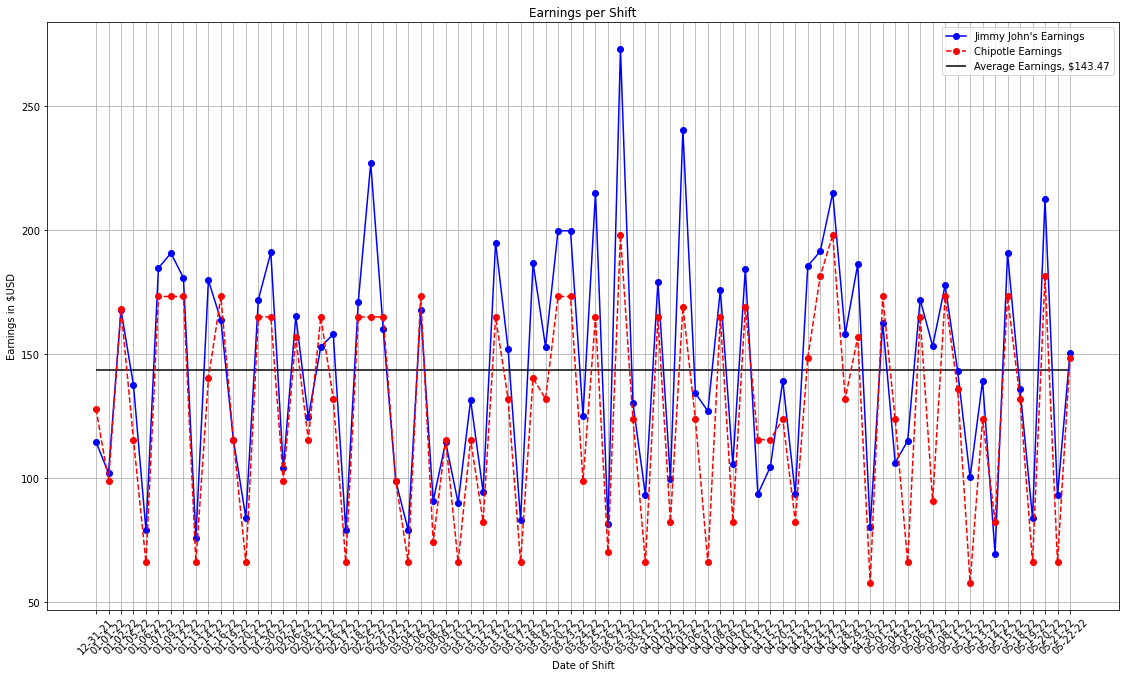

In [8]:
plot_earnings(dataframe)

In [27]:
# create dataframe from the documents, drop columns
dataframe = pd.DataFrame(documents)
# drop _id from dataframe
dataframe = dataframe.drop(columns=['_id'])

# drop outliers in mileage
dataframe = dataframe.loc[dataframe['starting_mileage'] > 0]

date_col = dataframe['date_of_shift']
weekday_list = []

weekday_dict = {
    '1':'monday',
    '2':'tuesday',
    '3':'wednesday',
    '4':'thursday',
    '5':'friday',
    '6':'saturday',
    '7':'sunday',
}

for date in date_col:
    datetime_object = datetime.strptime(date, '%m-%d-%y')
    
    current_day_numerical = datetime_object.isoweekday()
    
    day_of_week = weekday_dict[f'{current_day_numerical}']
    
    weekday_list.append(day_of_week)
    
dataframe.insert(0,'weekday',weekday_list)

dataframe = dataframe.rename(columns={
    'effective_wage':'combination_wage',
    'tips':'shift_payout',
    'earnings':'combined_earnings'
    
})

dataframe.insert(2,'tips',dataframe['shift_payout'] - (dataframe['change_in_mileage'] * 0.52))
dataframe.insert(3, 'DMR', (dataframe['change_in_mileage'] * 0.52))
dataframe.insert(5, 'wage_earnings', (dataframe['hours'] * current_wage))
dataframe.insert(5, 'actual_wage',round(((dataframe['tips']+dataframe['wage_earnings']) / dataframe['hours']),2) )


dataframe = dataframe.reset_index(drop=True)

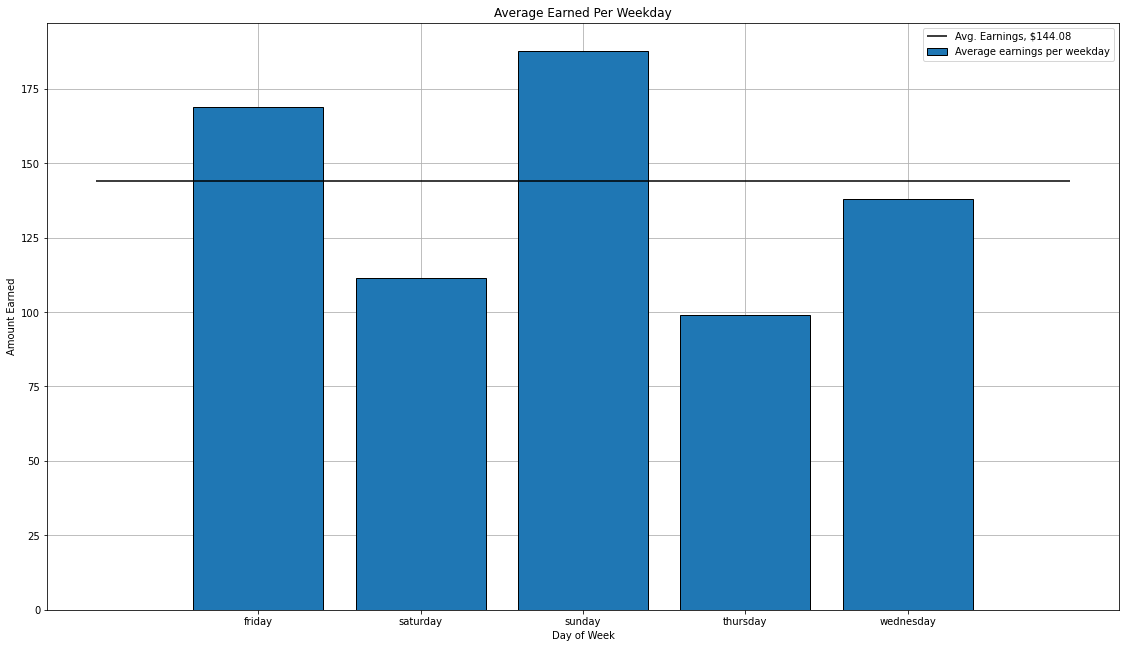

In [28]:
# set average earnings
avg_earnings = round(dataframe['combined_earnings'].mean(),2)

# create figure, make big
fig = plt.figure(figsize = (19.20,10.80))

# set list of weekdays in dataframe
day_list = dataframe['weekday'].unique()

# performe dataframe aggregations:

# group by weekday
avg_per_day_df = dataframe.groupby(by=['weekday']).mean()
#reset index
avg_per_day_df = avg_per_day_df.reset_index()
# drop the 1 shift from tuesday
avg_per_day_df = avg_per_day_df.drop([4])

#set cariables for graphing
x = avg_per_day_df['weekday']
y = avg_per_day_df['combined_earnings']

# plot the amounts earned per weekday
plt.bar(x,y, edgecolor='k', label='Average earnings per weekday', zorder=3)

# plot the average earned per shift for easy comparison
plt.hlines(avg_earnings, xmin=-1, xmax=len(x), color='k', label=f'Avg. Earnings, ${avg_earnings}', zorder=3.1)


plt.xlabel('Day of Week')
plt.ylabel('Amount Earned')
plt.title('Average Earned Per Weekday')

plt.grid()

plt.legend()
plt.savefig('visualizations/avg_per_weekday.png')
plt.show()

In [29]:
display_and_save('jj_earnings')

Saving Dataframe "jj_earnings" to JSON & CSV file ... 



,weekday,date_of_shift,tips,DMR,shift_payout,actual_wage,wage_earnings,hours,combined_earnings,combination_wage,old_job_earnings,old_job_comparison,starting_mileage,ending_mileage,change_in_mileage
0,wednesday,01-05-22,42.40,28.60,71.0,15.56,66.50,7.0,137.50,19.64,115.50,-22.0,75190,75245,55
1,thursday,01-06-22,22.80,18.20,41.0,15.20,38.00,4.0,79.00,19.75,66.00,-13.0,75255,75290,35
2,friday,01-07-22,49.12,35.88,85.0,14.18,99.75,10.5,184.75,17.60,173.25,-11.5,75300,75369,69
3,sunday,01-09-22,58.76,32.24,91.0,15.10,99.75,10.5,190.75,18.17,173.25,-17.5,75382,75444,62
4,wednesday,01-12-22,42.00,39.00,81.0,13.50,99.75,10.5,180.75,17.21,173.25,-7.5,75448,75523,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,wednesday,05-18-22,43.36,16.64,60.0,14.92,76.00,8.0,136.00,17.00,132.00,-4.0,81127,81159,32
72,thursday,05-19-22,29.88,16.12,46.0,16.97,38.00,4.0,84.00,21.00,66.00,-18.0,81170,81201,31
73,friday,05-20-22,77.32,30.68,108.0,16.53,104.50,11.0,212.50,19.32,181.50,-31.0,81212,81271,59
74,saturday,05-21-22,40.44,14.56,55.0,19.61,38.00,4.0,93.00,23.25,66.00,-27.0,81281,81309,28


In [59]:
jj_avg_miles_dict = {
    
    'wednesday': round((dataframe.loc[dataframe['weekday']== 'wednesday']['change_in_mileage'].mean()),2),
    'thursday': round((dataframe.loc[dataframe['weekday']== 'thursday']['change_in_mileage'].mean()),2),
    'friday': round((dataframe.loc[dataframe['weekday']== 'friday']['change_in_mileage'].mean()),2),
    'saturday': round((dataframe.loc[dataframe['weekday']== 'saturday']['change_in_mileage'].mean()),2),
    'sunday': round((dataframe.loc[dataframe['weekday']== 'sunday']['change_in_mileage'].mean()),2),
#     'monday': round((dataframe.loc[dataframe['weekday']== 'monday']['hours'].mean()),2),
#     'tuesday': round((dataframe.loc[dataframe['weekday']== 'tuesday']['hours'].mean()),2),
}
avg_miles_driven_shift=round(((jj_avg_miles_dict['wednesday'] +jj_avg_miles_dict['thursday'] +jj_avg_miles_dict['friday'] +
                  jj_avg_miles_dict['saturday'] +jj_avg_miles_dict['sunday']) / 5),2)

avg_miles_driven_week=round((jj_avg_miles_dict['wednesday'] +jj_avg_miles_dict['thursday'] +jj_avg_miles_dict['friday'] +
                  jj_avg_miles_dict['saturday'] +jj_avg_miles_dict['sunday']),2)


In [45]:
# ---------------------------------- shift & hours calculations ---------------------------------- #

jj_avg_hours_dict = {
    
    'wednesday': round((dataframe.loc[dataframe['weekday']== 'wednesday']['hours'].mean()),2),
    'thursday': round((dataframe.loc[dataframe['weekday']== 'thursday']['hours'].mean()),2),
    'friday': round((dataframe.loc[dataframe['weekday']== 'friday']['hours'].mean()),2),
    'saturday': round((dataframe.loc[dataframe['weekday']== 'saturday']['hours'].mean()),2),
    'sunday': round((dataframe.loc[dataframe['weekday']== 'sunday']['hours'].mean()),2),
#     'monday': round((dataframe.loc[dataframe['weekday']== 'monday']['hours'].mean()),2),
#     'tuesday': round((dataframe.loc[dataframe['weekday']== 'tuesday']['hours'].mean()),2),
   
}

jj_total_earnings = round(dataframe['combined_earnings'].sum(),2)
jj_num_shifts = dataframe['combined_earnings'].count()
jj_avg_earned_shift = round(dataframe['combined_earnings'].mean(),2)
jj_avg_hourly_wage = round(dataframe['combination_wage'].mean(),2)
avg_miles_driven = round(dataframe['change_in_mileage'].mean(),2)

chip_shift_earnings = 16.5 * (34/4) # 34hrs/wk divided by 4 days worked per week = (8.5)

chip_shift_diff = round((jj_avg_earned_shift - chip_shift_earnings),2)

if chip_shift_diff > 0: 
    pos_neg_shift = "+"
else: pos_neg_shift = "-"

jj_avg_hours_shift = round(((daily_avg_hours['wednesday'] +daily_avg_hours['thursday'] +daily_avg_hours['friday'] +
                      daily_avg_hours['saturday'] +daily_avg_hours['sunday']) / 5),2)

jj_avg_hours_week = round((daily_avg_hours['wednesday'] +daily_avg_hours['thursday'] +daily_avg_hours['friday'] +
                      daily_avg_hours['saturday'] +daily_avg_hours['sunday']),2)


# ---------------------------------- weekly calculations ---------------------------------- #

jj_avg_earnings_week = round((jj_avg_hours_week * jj_avg_hourly_wage),2)

chip_week_earnings = chip_shift_earnings * 4 # 4 days per week worked

chip_week_diff = round((jj_avg_earnings_week - chip_week_earnings),2)

if chip_week_earnings > jj_avg_earnings_week:
    pos_neg_week = "-"
else: pos_neg_week = "+"

# ---------------------------------- yearly calculations ---------------------------------- #

chip_year = chip_week_earnings * 52
jj_year = jj_avg_earnings_week * 52
chip_year_diff = round((jj_year - chip_year),2)

if chip_year > jj_year:
    pos_neg_year = "-"
else: 
    pos_neg_year = "+"

In [47]:
jj_avg_hours_dict

{'wednesday': 7.9,
 'thursday': 4.46,
 'friday': 9.03,
 'saturday': 5.42,
 'sunday': 10.34,
 'shift': 7.43,
 'weekly': 37.15}

In [46]:
print('---------------------------------------------------------------------------------------------------------------')
print('                   VOLATILE INFORMATION - SUBJECT TO DRASTIC CHANGE AS DATASET IS BUILT')
print('---------------------------------------------------------------------------------------------------------------')

print(f"Total earnings at JJs in {jj_num_shifts} shifts -> ${jj_total_earnings}")
print(f'')
print(f'You drive {avg_miles_driven} miles per shift on Average.')
print(f'')
print(f"Avg earned per Hour at JJs -> {jj_avg_hourly_wage}")
print(f'')
print(f"Avg hours per Shift at JJs -> {jj_avg_hours_shift}")
print(f'')
print(f'Avg hours per week at JJs -> {jj_avg_hours_week}')
print(f'')
print(f'Average earned per shift at JJs -> ${jj_avg_earned_shift}')
print(f'')
print(f'Average earned per shift at Chipotle -> ${chip_shift_earnings}')
print(f'')
print(f'Avg JJs weekly earnings = ${jj_avg_earnings_week}')
print(f'')
print(f'Avg Chipotle Weekly earnings = ${chip_week_earnings}')
print(f'')
print(f'Per shift take home is {pos_neg_shift} ${chip_shift_diff} in comparison to Chipotle per shift')
print(f'')
print(f'Per week take home is {pos_neg_week} ${chip_week_diff} in comparison to Chipotle, so far.')
print(f'')
print(f'Per year youll make {pos_neg_year} ${chip_year_diff} in comparison to Chipotle, so far.')

---------------------------------------------------------------------------------------------------------------
                   VOLATILE INFORMATION - SUBJECT TO DRASTIC CHANGE AS DATASET IS BUILT
---------------------------------------------------------------------------------------------------------------
Total earnings at JJs in 76 shifts -> $10949.77

You drive 53.0 miles per shift on Average.

Avg earned per Hour at JJs -> 19.25

Avg hours per Shift at JJs -> 7.43

Avg hours per week at JJs -> 37.15

Average earned per shift at JJs -> $144.08

Average earned per shift at Chipotle -> $140.25

Avg JJs weekly earnings = $715.14

Avg Chipotle Weekly earnings = $561.0

Per shift take home is + $3.83 in comparison to Chipotle per shift

Per week take home is + $154.14 in comparison to Chipotle, so far.

Per year youll make + $8015.28 in comparison to Chipotle, so far.


In [14]:
dataframe.describe()

,tips,DMR,shift_payout,actual_wage,wage_earnings,hours,combined_earnings,combination_wage,old_job_earnings,old_job_comparison,starting_mileage,ending_mileage,change_in_mileage
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,43.703158,27.560000,71.263158,15.526974,72.812500,7.664474,144.075921,19.249342,126.463553,-17.612368,78332.802632,78385.802632,53.000000
std,20.161635,10.281458,26.328878,2.867628,24.416887,2.570199,46.380714,3.281540,42.408217,19.542856,1899.889997,1896.689917,19.772034
min,-4.120000,4.160000,22.000000,8.910000,33.250000,3.500000,69.500000,13.360000,57.750000,-75.000000,75190.000000,75245.000000,8.000000
25%,30.130000,18.720000,48.750000,13.885000,47.500000,5.000000,100.062500,17.300000,82.500000,-26.000000,76826.500000,76922.250000,36.000000
50%,42.200000,27.040000,68.000000,15.055000,76.000000,8.000000,146.940000,18.950000,132.000000,-15.500000,78261.500000,78310.000000,52.000000
75%,53.020000,33.800000,87.000000,16.655000,95.000000,10.000000,180.000000,20.645000,165.000000,-7.000000,80162.250000,80228.750000,65.000000
max,108.040000,53.040000,159.000000,26.420000,114.000000,12.000000,273.000000,31.750000,198.000000,22.000000,81347.000000,81383.000000,102.000000


# TO_DO

- Enter method for updating mongo entries
    - pull entries
    - update via key:value
        
        
- Add day of week to data
    - import date/time, math your way to the day of the week
    - update the wage to $10 per hour


- expand utility of database_query() by class conversion.

    - explore class concepts and inheritance
    - write/re-write as needed to unbundle the methods and clean up how they function.
    
- examine how change is calculated and decide is the means of chipotle comparision is accurate. 
> Q: should another means be utilized to potentially provide more accurate results

- break down earnings into proper categories
    - tips
    - DMR
    - wage_earnings
    - sum all to create "combined_earnings"

# ------------------------------------ WORK IN PROGRESS ------------------------------------

from scipy.stats import linregress

print(f'{dataframe.columns}')
print()
x_input = input('X axis for scatter plot? ')
y_input = input('y axis for scatter plot? ')
print()
print()



# drop outliers
dataframe_no_outliers = dataframe.loc[dataframe['change_in_mileage'] > 0]

# set values based on input
x = dataframe_no_outliers[f'{x_input}']
y = dataframe_no_outliers[f'{y_input}']


# set figure params
fig = plt.figure(figsize = (19.20,10.80))
plt.grid()

#plot scatter
plt.scatter(x,y)

plt.xlabel(f'{x_input}')
plt.ylabel(f'{y_input}')


plt.show()

import seaborn as sn
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (19.20,10.80))

corrMatrix = dataframe.corr()
sn.heatmap(corrMatrix, annot=True)
plt.savefig('visualizations/heatmap_correlations.png')

# --------------------------------- END WORK IN PROGRESS --------------------------------